### Extracting data from the JSON files

In [63]:
SAMPLE_SIZE = 12000
TRAIN_SIZE = 7500
CUTOFF = 3
TARGET = 5000

In [12]:
# FOR BINARY CASE

import numpy as np
import json 
import pandas
from collections import Counter

business_ratings = { }
business_priors = Counter()

for index, line in enumerate(open("data/yelp_academic_dataset_business.json", "r")):
    json_data = json.loads(line)
    rating, bid = int(json_data["stars"]) <= CUTOFF, json_data["business_id"]
    if business_priors[rating] < TARGET:
        business_ratings[bid] = rating
        business_priors[rating] += 1
    
review_list = []
business_index = { }
for index, bid in enumerate(business_ratings.keys()):
    review_list.append([bid, business_ratings[bid], ""])
    business_index[bid] = index

for line in open("data/yelp_academic_dataset_review.json", "r"):
    json_data = json.loads(line)
    bid = json_data["business_id"]
    if bid in business_ratings:
        review_list[business_index[bid]][2] += (json_data["text"] + "\n")
               
review_pd = pandas.DataFrame(review_list, columns = ["Business ID", "Business Rating", "Review Text"])

In [13]:
review_pd.head()

,Business ID,Business Rating,Review Text
0,qQ_llmpx3ANoeiyG_6rasA,False,Bill came out to check on our garage door that...
1,mA6fwSD7HaXL1QG-jkb2Hw,False,Why is it that retail associates either bombar...
2,ykBWmSL1yDrAob2a20b2DQ,True,This is the place to go for an inexpensive ped...
3,VZYMInkjRJVHwXVFqeoMWg,True,I know. You are reading this and wanting to ri...
4,yDnRf8m_YI4AXHVGH6-fuQ,False,Sur La Table ...you sexy thing. You with your ...


### Tokenizing the review text

In [14]:
import sys
import string
import unicodedata
from sklearn.feature_extraction.text import CountVectorizer

tbl = dict.fromkeys(i for i in xrange(sys.maxunicode) if unicodedata.category(unichr(i)).startswith('P'))

def tokenize(text):
    return unicode(text).translate(tbl).lower().split()

vectorizer = CountVectorizer()
analyze = vectorizer.build_analyzer()

review_pd["Tokenized Text"] = review_pd["Review Text"].apply(analyze)

In [15]:
review_pd.head()

,Business ID,Business Rating,Review Text,Tokenized Text
0,qQ_llmpx3ANoeiyG_6rasA,False,Bill came out to check on our garage door that...,"[bill, came, out, to, check, on, our, garage, ..."
1,mA6fwSD7HaXL1QG-jkb2Hw,False,Why is it that retail associates either bombar...,"[why, is, it, that, retail, associates, either..."
2,ykBWmSL1yDrAob2a20b2DQ,True,This is the place to go for an inexpensive ped...,"[this, is, the, place, to, go, for, an, inexpe..."
3,VZYMInkjRJVHwXVFqeoMWg,True,I know. You are reading this and wanting to ri...,"[know, you, are, reading, this, and, wanting, ..."
4,yDnRf8m_YI4AXHVGH6-fuQ,False,Sur La Table ...you sexy thing. You with your ...,"[sur, la, table, you, sexy, thing, you, with, ..."


In [16]:
review_pd.shape

(10000, 4)

### Baseline Model

In [32]:
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as met

X = vectorizer.fit_transform(review_pd["Review Text"].values).toarray()
y = review_pd["Business Rating"].values

mb = GaussianNB()
mb.fit(X[:TRAIN_SIZE], y[:TRAIN_SIZE])
preds = mb.predict(X[TRAIN_SIZE:])

print met.accuracy_score(y[TRAIN_SIZE:], preds)

0.579


In [33]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met

mb = LogisticRegression()
mb.fit(X[:TRAIN_SIZE], y[:TRAIN_SIZE])
preds = mb.predict(X[TRAIN_SIZE:])

print met.accuracy_score(y[TRAIN_SIZE:], preds)

0.815666666667


### Manipulating data into LabeledSentences

In [18]:
from gensim.models.doc2vec import LabeledSentence
import numpy as np

class LabeledSentences:
    
    def __init__(self, series):
        self.series = series
        
    def __iter__(self):
        indexes = list(np.arange(len(self.series)))
        np.random.shuffle(indexes)
        for (index, wordlist) in self.series.iloc[indexes].iteritems():
            yield LabeledSentence(words = wordlist, tags = ['VEC_%s' % index])
            
sentences = LabeledSentences(review_pd["Tokenized Text"].copy())

### Learn vector representations for each word via Word2Vec

In [35]:
import multiprocessing
import gensim
from gensim.models import Doc2Vec

assert gensim.models.doc2vec.FAST_VERSION > -1, "This will be slow otherwise"
cores = multiprocessing.cpu_count()

model1 = Doc2Vec(dm = 1, min_count = 1, window = 5, size = 160, sample = 1e-4, negative = 5, 
                workers = cores, alpha = 0.025, min_alpha = 0.025)
model2 = Doc2Vec(dm = 0, min_count = 1, window = 10, size = 160, sample = 1e-4, negative = 5, 
                workers = cores, alpha = 0.025, min_alpha = 0.025)
model1.build_vocab(sentences)
model2.build_vocab(sentences)

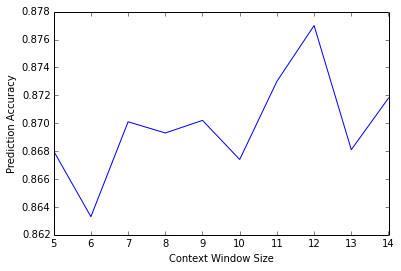

In [3]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
plt.xlabel("Context Window Size")
plt.ylabel("Prediction Accuracy")
plt.plot(np.arange(5, 15), [0.868, 0.8633, 0.8701, 0.8693, 0.8702, 0.8674, 0.873, 0.877, 0.8681, 0.8718])
plt.show()

### Learn vector representations for each review text via Doc2Vec

In [38]:
for epoch in range(10):
    model1.train(sentences)
    model2.train(sentences)
    model1.alpha -= 0.002
    model1.min_alpha = model1.alpha
    model2.alpha -= 0.002
    model2.min_alpha = model2.alpha
    print 'Done %s' % epoch

Done 0
Done 1
Done 2
Done 3
Done 4
Done 5
Done 6
Done 7
Done 8
Done 9


### Concatenate Review Rating with Vector

In [68]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met
best = -1
for _ in range(50):
    design_matrix, labels = [], []
    test_matrix, t_labels = [], []

    train_indices = set(np.random.choice(np.arange(len(model1.docvecs)), replace=False, size=TRAIN_SIZE))
    for index in xrange(len(model1.docvecs)):
        key = ("VEC_%s") % (index)
        if index in train_indices:
            design_matrix.append(np.append(model1.docvecs[key], model2.docvecs[key]))
            labels.append(review_pd["Business Rating"][index])
        else:
            test_matrix.append(np.append(model1.docvecs[key], model2.docvecs[key]))
            t_labels.append(review_pd["Business Rating"][index])

    design_matrix = np.array(design_matrix)
    labels = np.array(labels)

    test_matrix = np.array(test_matrix)
    t_labels = np.array(t_labels)
    
    
    logreg = LogisticRegression()
    logreg.fit(design_matrix, labels)

    preds = logreg.predict(test_matrix)
    print met.accuracy_score(t_labels, preds)
    best = max(best, met.accuracy_score(t_labels, preds))

print best

0.8336
0.8196
0.832
0.8316
0.8312
0.8304
0.8256
0.826
0.8212
0.8284
0.824
0.8256
0.8364
0.84
0.8208
0.8224
0.8204
0.8392
0.8192
0.832
0.8276
0.8336
0.8316
0.8252
0.82
0.8268
0.8312
0.816
0.8296
0.8248
0.828
0.8236
0.8268
0.8296
0.8208
0.8236
0.8276
0.8136
0.8216
0.8216
0.8208
0.8336
0.8272
0.812
0.818
0.8256
0.8268
0.8204
0.8308
0.824
0.84


(array([    0.,     0.,   103.,   165.,   371.,   763.,  1241.,  1924.,
         1969.,  1417.,  1047.]),
 array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
         5.5]),
 <a list of 11 Patch objects>)

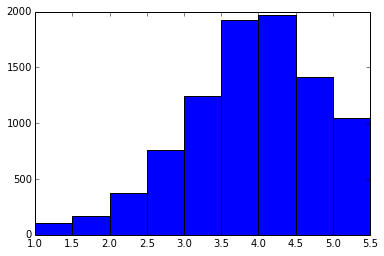

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(labels,bins=[0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5])

In [24]:
labels_binary = (labels >= 3).astype(int)
t_labels_binary = (t_labels >= 3).astype(int)

array([0, 0, 0, ..., 0, 0, 0])

In [25]:
t_labels_binary.sum() * 1.0 / len(t_labels_binary)

0.0

### Input data into Binomial Model

In [65]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met

logreg = LogisticRegression()
logreg.fit(design_matrix, labels)

preds = logreg.predict(test_matrix)
print met.accuracy_score(t_labels, preds)

0.8384


In [35]:
met.confusion_matrix(t_labels_binary, preds)

array([[1254,  292],
       [ 241, 1213]])

In [36]:
met.precision_score(t_labels_binary, preds)

0.80598006644518272

In [37]:
met.recall_score(t_labels_binary, preds)

0.83425034387895458

### Sentiment Exploration

In [12]:
model.most_similar('busy')

[(u'storesbusinesses', 0.21904942393302917),
 (u'sharpening', 0.21502238512039185),
 (u'vitrineskylight', 0.2082488089799881),
 (u'norfolk', 0.2068164348602295),
 (u'churned', 0.20456013083457947),
 (u'tiburon', 0.20357173681259155),
 (u'pastriesdo', 0.19825713336467743),
 (u'scotchguard', 0.19718888401985168),
 (u'surveiller', 0.1971379816532135),
 (u'76$', 0.1965305209159851)]

In [13]:
model.most_similar('good')

[(u'pointsgreat', 0.22538119554519653),
 (u'rangoona', 0.21524882316589355),
 (u'newsletter', 0.20920872688293457),
 (u'strikeinthecitycom', 0.20919795334339142),
 (u'soupsquality', 0.2076713591814041),
 (u'firefighters', 0.20400795340538025),
 (u'depicted', 0.20284488797187805),
 (u'riski', 0.20240798592567444),
 (u'httpwwwyelpcombizppmyihmcil5bocusjssdwahrid=m3r1tfbnwtzgb8xxuclja',
  0.20213507115840912),
 (u'lanky', 0.20079487562179565)]

In [27]:
model.most_similar('service')

[(u'terisa', 0.5031445026397705),
 (u'reviewpost', 0.4956582188606262),
 (u'slowsince', 0.4931017756462097),
 (u'pratice', 0.4908463954925537),
 (u'televisi\xf3n', 0.4890173375606537),
 (u'customer', 0.48583510518074036),
 (u'food', 0.4808298945426941),
 (u'presentation', 0.4737012982368469),
 (u'ambience', 0.47268861532211304),
 (u'ambiance', 0.47012561559677124)]

### Input data into Multiclass Logistic Regression Model

In [2]:
# FOR MULTINOMIAL CASE

import numpy as np
import json 
import pandas
from collections import Counter

TARGET = 2000
business_classes = { 1 : 0, 1.5: 0, 2: 0, 2.5 : 0, 3 : 1, 3.5 : 2, 4 : 3, 4.5 : 4, 5 : 5 }
business_priors = Counter()
business_ratings = { }

for index, line in enumerate(open("data/yelp_academic_dataset_business.json", "r")):
    json_data = json.loads(line)
    rating, bid = json_data["stars"], json_data["business_id"]
    if business_priors[business_classes[rating]] < TARGET:
        business_priors[business_classes[rating]] += 1
        business_ratings[bid] = rating
    
review_list = []
business_index = { }
for index, bid in enumerate(business_ratings.keys()):
    review_list.append([bid, business_ratings[bid], ""])
    business_index[bid] = index

for line in open("data/yelp_academic_dataset_review.json", "r"):
    json_data = json.loads(line)
    bid = json_data["business_id"]
    if bid in business_ratings:
        review_list[business_index[bid]][2] += (json_data["text"] + "\n")
               
review_pd = pandas.DataFrame(review_list, columns = ["Business ID", "Business Rating", "Review Text"])

In [6]:
review_pd["Tokenized Text"] = review_pd["Review Text"].apply(tokenize)
review_pd.head()

,Business ID,Business Rating,Review Text,Tokenized Text
0,qQ_llmpx3ANoeiyG_6rasA,5.0,Bill came out to check on our garage door that...,"[bill, came, out, to, check, on, our, garage, ..."
1,mA6fwSD7HaXL1QG-jkb2Hw,4.0,Why is it that retail associates either bombar...,"[why, is, it, that, retail, associates, either..."
2,ykBWmSL1yDrAob2a20b2DQ,2.5,This is the place to go for an inexpensive ped...,"[this, is, the, place, to, go, for, an, inexpe..."
3,VZYMInkjRJVHwXVFqeoMWg,3.5,I know. You are reading this and wanting to ri...,"[i, know, you, are, reading, this, and, wantin..."
4,GXNLitPTpkBwc_IXGzBEvQ,4.5,"Edited as of July 16, 2010 to make this a 5 st...","[edited, as, of, july, 16, 2010, to, make, thi..."


In [49]:
design_matrix, labels = [], []
test_matrix, t_labels = [], []

train_indices = set(np.random.choice(np.arange(len(model.docvecs)), replace=False, size=TRAIN_SIZE))
for index in xrange(len(model.docvecs)):
    key = ("VEC_%s") % (index)
    if index in train_indices:
        design_matrix.append(model.docvecs[key])
        labels.append(business_classes[review_pd["Business Rating"][index]])
    else:
        test_matrix.append(model.docvecs[key])
        t_labels.append(business_classes[review_pd["Business Rating"][index]])
    
design_matrix = np.array(design_matrix)
labels = np.array(labels).astype(int)

test_matrix = np.array(test_matrix)
t_labels = np.array(t_labels).astype(int)

In [50]:
from sklearn.linear_model import LogisticRegression
import sklearn.metrics as met

logreg = LogisticRegression(multi_class = "multinomial", solver = "lbfgs")
logreg.fit(design_matrix, labels)

preds = logreg.predict(test_matrix)
print met.accuracy_score(t_labels, preds)

0.475333333333


(array([ 530.,  520.,  492.,  497.,  475.,  486.]),
 array([ 0.        ,  0.83333333,  1.66666667,  2.5       ,  3.33333333,
         4.16666667,  5.        ]),
 <a list of 6 Patch objects>)

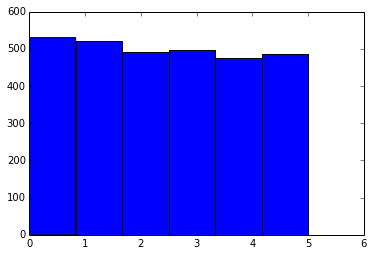

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.hist(t_labels, bins = 6)

In [79]:
stars = np.array(business_ratings.values())
(stars == 3).sum()

8335